# Import

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Pandas & ML
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# Third party
import evidently
import mlflow
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Pandas & ML
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

# ML Flow setup

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("P7 ML")
mlflow.autolog()


2024/02/23 14:58:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/23 14:58:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


# Split train/test
To keep some test data not seen by gridsearch

In [3]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl").set_index(
    "SK_ID_CURR"
)
app_test = pd.read_pickle("../data/processed/app_test_cleaned.pkl").set_index(
    "SK_ID_CURR"
)  # used for datadrift only

In [4]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 243 entries, NAME_CONTRACT_TYPE to FE_PAYMENT_RATE
dtypes: bool(130), float64(71), int64(42)
memory usage: 305.6 MB


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

# Profits and Loss function

In [6]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [7]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(y_pred, y_true, interest=0.04, goods_recover_rate=0.60):
    # ajouter type casting
    # todo X en param
    # df.apply(pnl)
    # y_proba
    # interest  et GOODS_P en param
    # interest = 0.04
    # goods_recover_rate = 0.60
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + interest) + seized_goods,
        pnl,
    )
    return pnl.sum()

### Create customer scorer from custom pnl function

In [8]:
from sklearn.metrics._scorer import make_scorer

In [9]:
pnl_scorer = make_scorer(pnl, greater_is_better=True)

# Naive undersampler to fix target imbalance

In [10]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [11]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [12]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

TARGET
0    24825
1    24825
Name: count, dtype: int64

# Pipeline

In [13]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [14]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [15]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring=pnl_scorer)
# grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

2024/02/23 14:58:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c8caf33c7a8741f892a6db0db7500735', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/23 14:58:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/02/23 14:58:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way 

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring=make_scorer(pnl), verbose=3)

In [16]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.075303,0.046976,0.64058,0.004846,{},NaN,NaN,NaN,NaN,NaN,1


In [17]:
y_pred = grid.predict(X_test)

2024/02/23 14:59:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/02/23 14:59:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handlin

In [18]:
y_pred.shape

(46127,)

In [19]:
X_train.shape

(261384, 242)

# Proba predict treshold

In [20]:
# faire varier seuil et afficher graphiquement resultats

In [21]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [22]:
# y_pred = log_reg.predict(X_test)

In [23]:
# y_pred

# Scoring metric

In [24]:
y_pred.mean()

0.346651635701433

In [25]:
metrics.accuracy_score(y_test, y_pred)

0.6832007284236998

In [26]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


### Custom PnL

In [27]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ 55.5M
P&L avec prédictions parfaites : $ 1.02B


In [54]:
mlflow.log_metric("custom_pnl", pnl(y_pred, y_test))

In [28]:
y_pred.mean()

0.346651635701433

In [30]:
y_test.mean()

0.08149240141348885

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [31]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,
152651,203760.0,21748.5,180000.0
181007,260640.0,19615.5,225000.0
323900,1288350.0,37800.0,1125000.0
159192,508495.5,24462.0,454500.0
357254,792346.5,26316.0,684000.0
318688,1082214.0,31770.0,945000.0
107296,675000.0,37692.0,675000.0
166481,450000.0,22977.0,450000.0
382014,337500.0,16875.0,337500.0


In [32]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [33]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[0.015559575268789603, 0.066602310424602, 0.015234338616241946,
        ..., 18311.654153463598, -0.012526101609352526,
        0.0064025271272863185],
       [-0.15732459438442822, -0.10866692753487696, 0.015234338616241946,
        ..., -36549.637429658425, -0.17794907242227667,
        0.0023386842794577262],
       [0.015559575268789603, -0.10866692753487696, 0.015234338616241946,
        ..., -13037.655322606133, -0.15159620167763102,
        0.001312494249059777],
       ...,
       [0.015559575268789603, -0.10866692753487696, 0.015234338616241946,
        ..., -44386.964798675865, -0.196561330968, -0.03922031240535754],
       [0.015559575268789603, 0.066602310424602, 0.015234338616241946,
        ..., -36549.637429658425, 0.16263786433030528,
        -0.019153016490620775],
       [0.015559575268789603, -0.10866692753487696, 0.015234338616241946,
        ..., -53791.75764149678, 0.41309574668323634,
        0.017021698298056755]], dtype=object)

In [34]:
X_train.sample()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,FE_DAYS_EMPLOYED_PERC,FE_INCOME_CREDIT_PERC,FE_INCOME_PER_PERSON,FE_ANNUITY_INCOME_PERC,FE_PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
239887,0,0,1,0,112500.0,526491.0,27009.0,454500.0,0.008866,-20128,...,False,False,False,False,False,NaN,0.213679,112500.0,0.24008,0.0513


In [35]:
explainer

In [36]:
len(shap_values)

46127

In [37]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [38]:
X_test.shape

(46127, 242)

In [39]:
X_test.shape

(46127, 242)

In [40]:
def shap_for_one(df, idx):
    """
    Return 20
    TODO
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_INCOME_TOTAL': 6.016839879248108,
  'AMT_CREDIT': 5.356523847856535,
  'AMT_ANNUITY': 1.4069399688101707,
  'FE_INCOME_PER_PERSON': 1.1422935688375404,
  'DAYS_BIRTH': -0.00041357024039817374,
  'OBS_30_CNT_SOCIAL_CIRCLE': -0.0028454169114250955,
  'REGION_RATING_CLIENT': -0.0028916588721245667,
  'FLAG_WORK_PHONE': -0.0028920326660970305,
  'NAME_EDUCATION_TYPE_Higher education': -0.002892883618148021,
  'NAME_INCOME_TYPE_Pensioner': -0.002893094504948908},
 'bottom': {'AMT_GOODS_PRICE': -13.183968286310199,
  'DAYS_REGISTRATION': -0.04160327047084061,
  'DAYS_ID_PUBLISH': -0.015021696315739744,
  'DAYS_LAST_PHONE_CHANGE': -0.0066066919155747745,
  'OBS_60_CNT_SOCIAL_CIRCLE': -0.0029531650847410954,
  'REGION_RATING_CLIENT_W_CITY': -0.0029097002040122384,
  'NAME_EDUCATION_TYPE_Secondary / secondary special': -0.0029055372237232068,
  'EXT_SOURCE_2': -0.0029054918714107552,
  'CNT_CHILDREN': -0.0029011069826058783,
  'DEF_30_CNT_SOCIAL_CIRCLE': -0.0029008435335789087}}

In [41]:
idx = X_test.sample().index[0]

In [42]:
X_test.loc[X_test.sample().index[0], :]

NAME_CONTRACT_TYPE               0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  1
CNT_CHILDREN                     0
AMT_INCOME_TOTAL           72000.0
                            ...   
FE_DAYS_EMPLOYED_PERC     0.089794
FE_INCOME_CREDIT_PERC     0.471143
FE_INCOME_PER_PERSON       36000.0
FE_ANNUITY_INCOME_PERC    0.211688
FE_PAYMENT_RATE           0.099735
Name: 376190, Length: 242, dtype: object

In [43]:
def shap_for_one(df, idx):
    """
    Return 10 top
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_GOODS_PRICE': 13.559652303278847,
  'DAYS_ID_PUBLISH': -0.015384741520731417,
  'DAYS_LAST_PHONE_CHANGE': -0.015519258001089267,
  'DAYS_BIRTH': -0.017485018050453327,
  'FLAG_EMP_PHONE': -0.017609500716100363,
  'OBS_60_CNT_SOCIAL_CIRCLE': -0.017609648615810318,
  'EXT_SOURCE_2': -0.017610085122987295,
  'FLAG_DOCUMENT_6': -0.01761146580858703,
  'NAME_EDUCATION_TYPE_Secondary / secondary special': -0.017611725725493764,
  'HOUR_APPR_PROCESS_START': -0.017612099964310367},
 'bottom': {'AMT_CREDIT': -7.515244688246338,
  'AMT_INCOME_TOTAL': -1.1504017433262608,
  'FE_INCOME_PER_PERSON': -0.36516704257570987,
  'AMT_ANNUITY': -0.355895162727763,
  'DAYS_REGISTRATION': -0.020824755482866664,
  'NAME_INCOME_TYPE_Pensioner': -0.017617144991653545,
  'OBS_30_CNT_SOCIAL_CIRCLE': -0.017615344276746915,
  'FLAG_DOCUMENT_3': -0.017613918907813674,
  'CNT_CHILDREN': -0.017613396628697257,
  'DEF_30_CNT_SOCIAL_CIRCLE': -0.0176133472127363}}

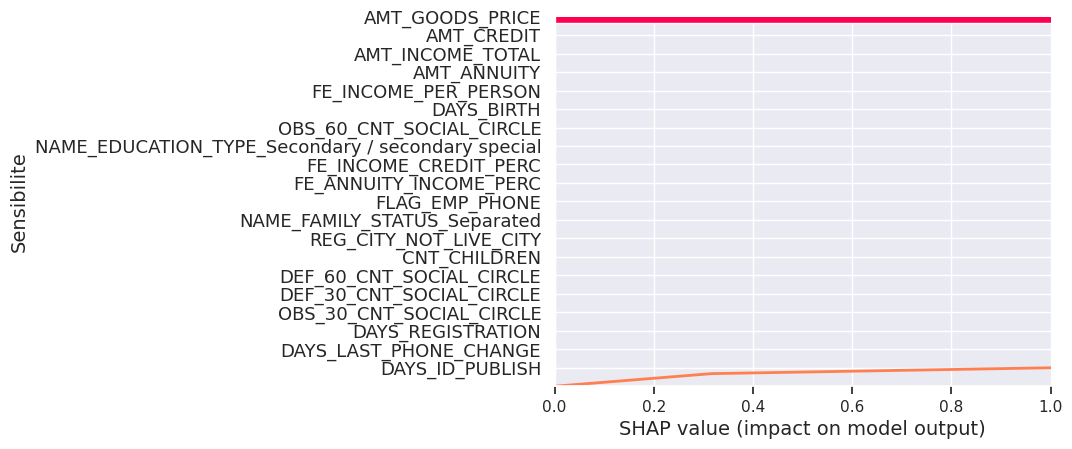

In [44]:
shap_dict = shap_for_one(X_test, X_test.sample().index[0])
# merge top and bottom into one dict
shap_dict["top"].update(shap_dict["bottom"])
keys = np.fromiter(shap_dict["top"].keys(), dtype=object)
values = np.fromiter(shap_dict["top"].values(), dtype=float)
shap.bar_plot(
    values,
    feature_names=keys,
    max_display=20,
)

In [45]:
np.fromiter(shap_dict["top"].keys(), dtype=object)

array(['AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'CNT_CHILDREN', 'REG_CITY_NOT_LIVE_CITY',
       'NAME_FAMILY_STATUS_Separated', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       'AMT_ANNUITY', 'FE_INCOME_PER_PERSON', 'DAYS_BIRTH',
       'OBS_60_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'FE_INCOME_CREDIT_PERC', 'FE_ANNUITY_INCOME_PERC',
       'FLAG_EMP_PHONE'], dtype=object)

In [46]:
explainer.shap_values(X_test.sample(1))[0]

array([0.015559575268789603, -0.10866692753487696, 0.015234338616241946,
       0.6244685338270219, 64937.994521901994, -512724.4966079312,
       -20775.857857769388, 695375.8748291257, 8.661550772628401e-05,
       -53.301168025118365, nan, 616.3745771429832, 592.2410314368661,
       nan, 0.0, -0.07942108494967631, -0.026892815443024225,
       -0.0036461769218326273, 0.011994151953432206,
       0.0052785549789444094, 0.7296734632962983, 0.01630270544405469,
       -0.03470358871495799, 0.15269525574450146, 0.002932182001512619,
       -0.0013171716901649948, -0.0013034461157566295,
       -0.017446824003384345, -0.054631064351263525, 0.05170302750618119,
       nan, -0.09708422966656961, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       2.0203990440436175, 1.1988976478342188, -2.2184026

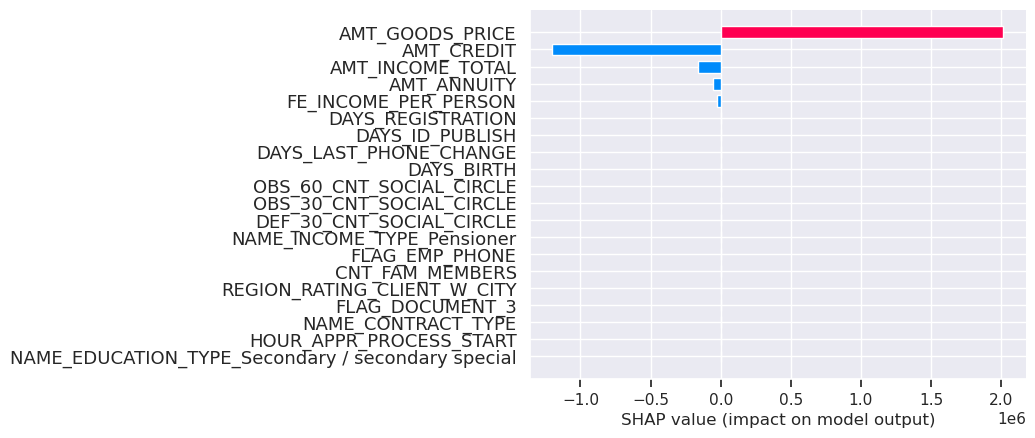

In [47]:
# explainer for only 1 sample row
# TODO prendre que les tops
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [48]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

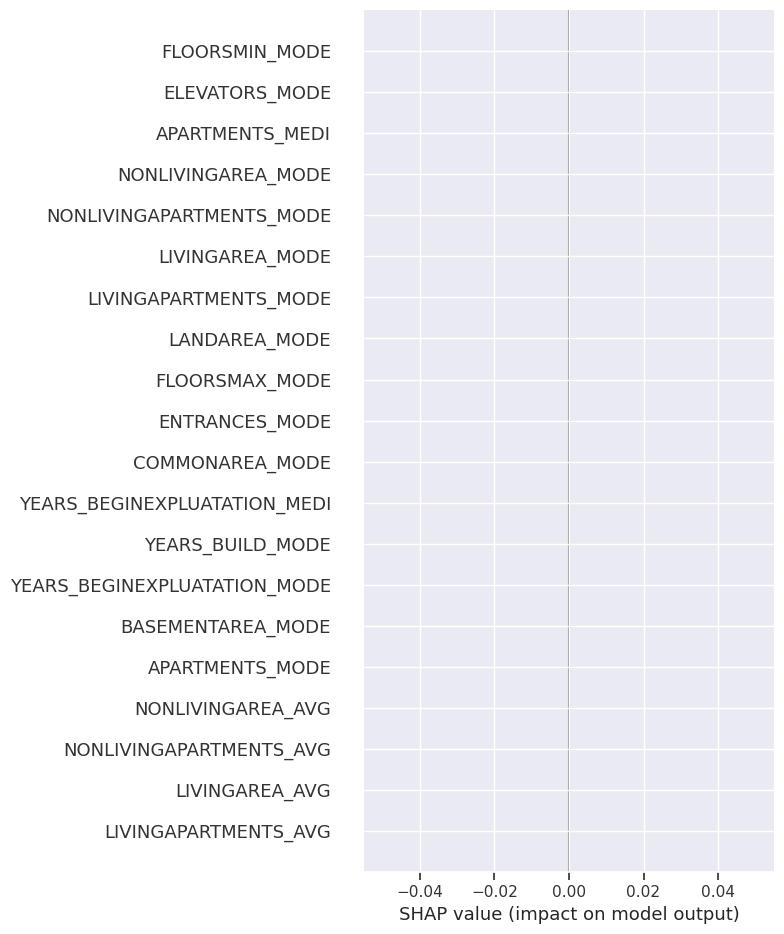

In [49]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [50]:
# Third party
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

# data_drift_report = Report(
#     metrics=[
#         DataDriftPreset(),
#     ]
# )

# data_drift_report.run(
#     reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
#     current_data=app_test.sample(frac=0.05),
#     # column_mapping=None,
# )

# data_drift_report.save_html("../reports/data_drift_report.html")

In [51]:
# ! firefox ../reports/data_drift_report.html

# Save trained model

In [52]:
# Standard
import pickle

with open("../models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("../models/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

f.close()

In [53]:
grid.best_estimator_.predict_proba(pd.DataFrame(X_test.iloc[0, :]).T)

array([[0.60942763, 0.39057237]])